# Практическая работа №5: Элементы регрессионного анализа. Выборочные прямые среднеквадратической регрессии. Корреляционное отношение

Выполнил студент гр. 9372 Аксёнов Александр, вариант 2.

## Цель работы
Ознакомление с основными положениями метода наименьших квадратов
(МНК), со статистическими свойствами МНК оценок, с понятием функции регрессии и роли МНК в регрессионном анализе, с корреляционным
отношением, как мерой тесноты произвольной (в том числе и линейной)
корреляционной связи.


## Основные теоретические положения
Основные теоретические положения

## Постановка задачи
Для заданной двумерной выборки (𝑋, 𝑌 ) построить уравнения выборочных прямых среднеквадратической регрессии. Полученные линейные
функции регрессии отобразить графически. Найти выборочное корреляционное отношение. Полученные результаты содержательно проинтерпретировать.


## Порядок выполнения работы
1. Отобразить двумерную выборку на графике.
2.  Для заданной выборки построить уравнения средней квадратичной
регрессии 𝑥 на 𝑦 и 𝑦 на 𝑥 соответственно. Построить полученные
прямые на множестве выборки. Объяснить результаты.
3.  Составить корреляционную таблицу для нахождения выборочного корреляционного отношения. Убедиться, что неравенства $𝜂_{𝑥𝑦} \geq |𝑟_{𝑥𝑦}|$ и $𝜂_{𝑦𝑥} \geq |𝑟_{𝑥𝑦}|$ выполняются.
4. Для заданной выборки построить корреляционную кривую параболического вида $𝑦 = 𝑎𝑥^2 + 𝑏𝑥 + 𝑐$. Сделать выводы.
5. Для заданной выборки построить нелинейные корреляционные кривые c помощью МНК в зависимости от номера варианта:
  1. степенная функция – $𝑦 = 𝑎𝑥^𝑏$;
  2. показательная функция – $𝑦 = 𝑎*exp(𝑏𝑥)$;
  3. дробно-линейная функция – $𝑦 =1/(𝑎𝑥 + 𝑏)$;
  4. логарифмическая функция – $𝑦 = 𝑎 ln 𝑥 + 𝑏$;
  5. обратно пропорциональная функция – $𝑦 = 𝑎/𝑥 + 𝑏$;
  6. дробно-рациональная функция – $𝑦 = 𝑥/(𝑎𝑥 + 𝑏)$
.
6. Вычислить следующие показатели качества регрессии для каждой
кривой и сделать выводы:
* теоретический коэффициент детерминации $𝑅^2$;
* средняя квадратическая ошибка $𝑆_𝜀$;
* средняя ошибка аппроксимации (приближения) $𝐴$.

## Выполнение работы

Подготовительная часть

In [35]:
#Загрузка выборки
sample <- read.csv('./sample_data/pokemons_sample.csv', sep = ";")
defense_stats <- sample$defense
attack_stats <- sample$special_attack
sample_cardinality <- length(defense_stats)

# 1. Найдём всё необходимое для выборки(см. предыдущие работ)
##Ранжированный ряд
sorted_sample <- sort(defense_stats)

##Дискретный стат. ряд
descrete_series <- data.frame(
  intervals = unique(sorted_sample),
  abs_freqs = as.vector(table(defense_stats))
)
descrete_series$rel_freqs = as.vector(prop.table(descrete_series$abs))

##По правилу Стёрджеса
number_of_intervals <- 1 + floor(log2(length(defense_stats)))

##Минимальное и максимальное значения выборки
x_min <- min(defense_stats)
x_max <- max(defense_stats)

##Размах
range <- x_max - x_min

##Шаг
step <- range / number_of_intervals
##Итоговый шаг интервального ряда - округлённый шаг из предыдущей строки
interval_step <- ceiling(step)

##Перебор
overstep <- number_of_intervals * (interval_step - step)

x0 <- x_min - overstep

breaks <- 1:(number_of_intervals + 1)
for (num in breaks){
  if (num == 1){
    breaks[num] <- x0
  }
  else breaks[num] <- breaks[num - 1] + interval_step
}


intervals <- list()
for (i in 1:(length(breaks) - 1)){
  intervals[[i]] <- c(breaks[i], breaks[i+1])
}

##Интервальный ряд(веса)
interval_absolute_frequencies <- table(cut(defense_stats, breaks = breaks))
##Интервальный ряд(частости)
interval_relative_frequencies <- prop.table(interval_absolute_frequencies)
##Интервальный стат. ряд
defense_interval_series <- data.frame(
  intervals = I(intervals),
  abs_freqs = as.vector(interval_absolute_frequencies),
  rel_freqs = as.vector(interval_relative_frequencies)
)

##Накопленные частоты интервального рядa
accumulated_interval_rel_freqs <- c()
for (i in 1:length(defense_interval_series$rel_freqs)){
  accumulated_interval_rel_freqs[i] <- 0
  for (j in 1:i){
    accumulated_interval_rel_freqs[i] <- accumulated_interval_rel_freqs[i] + defense_interval_series$rel_freqs[j]
  }
}

##Центры интервалов
defense_interval_centers <- c()
for (i in (1:length(breaks) - 1)){
  defense_interval_centers[i] <- (breaks[i] + breaks[i+1]) / 2
}

sorted_attack_stats <- sort(attack_stats)

##Дискретный стат. ряд
descrete_attack_series <- data.frame(
  intervals = unique(sorted_attack_stats),
  abs_freqs = as.vector(table(attack_stats))
)
descrete_attack_series$rel_freqs = as.vector(prop.table(descrete_attack_series$abs))

##По правилу Стёрджеса
number_of_intervals <- 1 + floor(log2(length(attack_stats)))

##Минимальное и максимальное значения выборки
min_attack <- min(attack_stats)
max_attack <- max(attack_stats)

##Размах
range_of_attack <- max_attack - min_attack

##Шаг
step_for_attack <- range_of_attack / number_of_intervals
##Итоговый шаг интервального ряда - округлённый шаг из предыдущей строки
interval_step_for_attack <- ceiling(step_for_attack)

##Перебор
overstep_for_attack <- number_of_intervals * (interval_step_for_attack - step_for_attack)

x0 <- min_attack - overstep_for_attack


attack_breaks <- 1:(number_of_intervals + 1)
for (num in attack_breaks){
  if (num == 1){
    attack_breaks[num] <- x0
  }
  else attack_breaks[num] <- attack_breaks[num - 1] + interval_step_for_attack
}


attack_intervals <- list()
for (i in 1:(length(attack_breaks) - 1)){
  attack_intervals[[i]] <- c(attack_breaks[i], attack_breaks[i+1])
}

##Интервальный ряд(веса)
attack_interval_absolute_frequencies <- table(cut(attack_stats, breaks = attack_breaks))
##Интервальный ряд(частости)
attack_interval_relative_frequencies <- prop.table(attack_interval_absolute_frequencies)
##Интервальный стат. ряд
attack_interval_series <- data.frame(
  intervals = I(attack_intervals),
  abs_freqs = as.vector(attack_interval_absolute_frequencies),
  rel_freqs = as.vector(attack_interval_relative_frequencies)
)

##Центры интервалов
attack_interval_centers <- c()
for (i in (1:length(attack_breaks) - 1)){
  attack_interval_centers[i] <- (attack_breaks[i] + attack_breaks[i+1]) / 2
}

mean_of_attack_interval_series <- sum(attack_interval_centers * attack_interval_series$rel_freqs) 
mean_of_defense_interval_series <- sum(defense_interval_centers * defense_interval_series$rel_freqs)

attack_dispersion <- sum((attack_interval_centers - mean_of_attack_interval_series)^ 2 * attack_interval_series$rel_freqs)
defense_dispersion <- sum((defense_interval_centers - mean_of_defense_interval_series)^ 2 * defense_interval_series$rel_freqs)

attack_std <- sqrt(attack_dispersion)
defense_std <- sqrt(defense_dispersion)

# 2. Построим двумерный интервальный вариационный ряд
two_dimensional_interval_series <- data.frame(
  def_stats = defense_interval_series$intervals,
  def_stats_abs_freqs = defense_interval_series$abs_freqs,
  attack_stats = attack_interval_series$intervals,
  attack_stats_abs_freqs = attack_interval_series$abs_freqs
)





,19,43,67,91,115,139,163
22,1,2,3,0,1,0,0
54,5,12,8,11,3,3,1
86,2,9,12,15,7,1,0
118,0,2,1,1,2,2,1
150,0,2,0,0,0,0,0
182,0,2,1,0,0,0,0
214,0,0,1,0,0,0,0


### 1. Отобразим двумерную выборку на графике

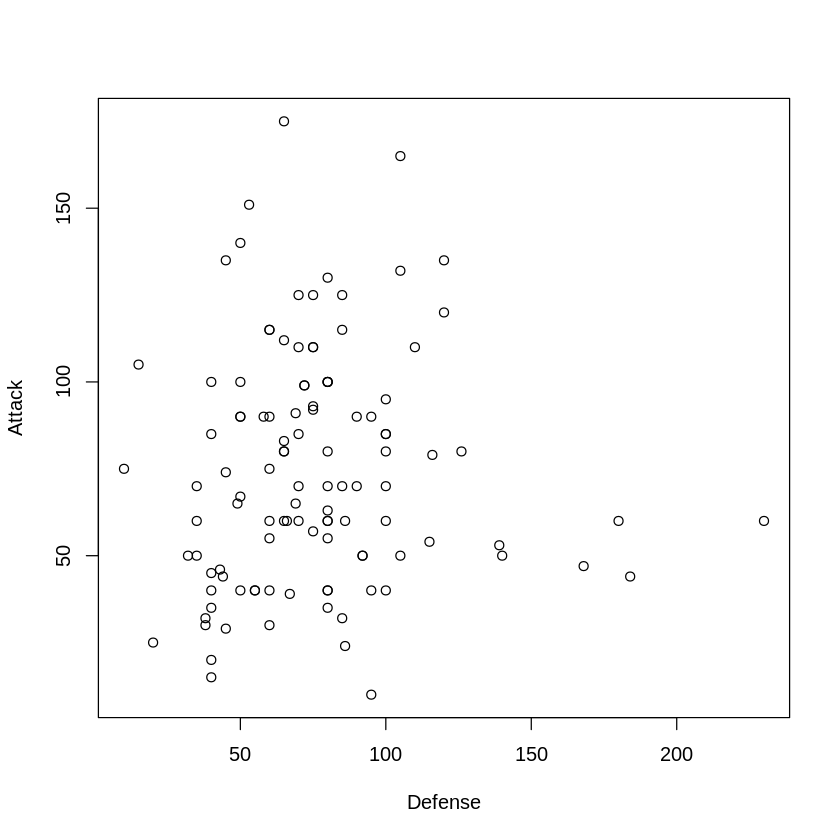

In [43]:
x_plot_values <- defense_stats
y_plot_values <- attack_stats

plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")

###2. Для заданной выборки построим уравнения средней квадратичной регрессии 𝑥 на 𝑦 и 𝑦 на 𝑥 соответственно.

Для поиска коэффициента корреляции рассчитаем коэффициент ковариации

In [82]:
X <- defense_stats
Y <- attack_stats
n <- sample_cardinality

cov <- 0
for (i in 1:sample_cardinality){
  cov = cov + (X[i] - x_mean) * (Y[i] - y_mean)
}
cov = cov / n
sprintf("Коэффициент ковариции = %f ", r)

[1] "Коэффициент ковариции = 0.038301 "

Найдём коэффициент корреляции

In [83]:
r <- cov  / (attack_std * defense_std)
sprintf("Коэффициент корреляции = %f ", r)

[1] "Коэффициент корреляции = 0.038301 "

Уравнение линейной регрессии $Y$ на $X$

In [84]:
k_yx <- r * y_std / x_std
b_yx <- y_mean - k_yx * x_mean
sprintf("y_x = %fx + %f", k_yx, b_yx)

[1] "y_x = 0.038132x + 71.412763"

Это означает, что с увеличением параметра $x$ на 1 единицу параметр $y$ увеличивается в среднем на 0.0381

Уравнение линейной регрессии $X$ на $Y$


[1] "x_y = 0.038470y + 74.202735"

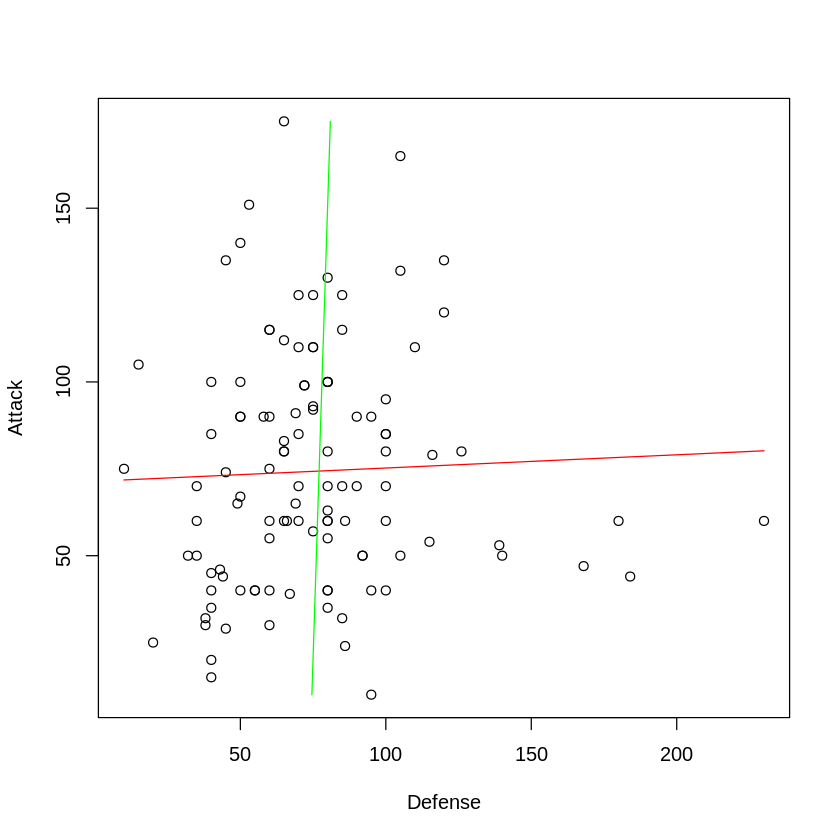

In [87]:
k_xy <- r * x_std / y_std
b_xy <- x_mean - k_xy * y_mean
sprintf("x_y = %fy + %f", k_xy, b_xy)

plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")
lines(x_plot_values, k_yx * x_plot_values + b_yx, col="red")
lines(k_xy * y_plot_values + b_xy, y_plot_values, col="green")

Это означает, что с увеличением параметра $y$ на 1 единицу параметр $x$ увеличивается в среднем на 0.0385

###3. Составим корреляционную таблицу для нахождения выборочного корреляционного отношения.

In [49]:
# 3. Построим корреляционную таблицу
##Найдём пары элементов (xi, yj). Возьмём центры соотв. интервалов
x_values <- defense_interval_series$intervals
y_values <- attack_interval_series$intervals

x_centers <- round(defense_interval_centers)
y_centers <- round(attack_interval_centers)

x_mean <- mean_of_defense_interval_series
y_mean <- mean_of_attack_interval_series

x_std <- defense_std
y_std <- attack_std

correlation_table <- matrix(0, nrow = number_of_intervals, ncol = number_of_intervals)
for (i in 1:number_of_intervals){
  for (j in 1:number_of_intervals){
    for (k in 1:sample_cardinality){
      if ((defense_stats[k] > x_values[[i]][1] && defense_stats[k] <= x_values[[i]][2]) && (attack_stats[k] > y_values[[j]][1] && attack_stats[k] <= y_values[[j]][2])){
        correlation_table[i,j] = correlation_table[i,j] + 1
      }
    }
  }
}

rownames(correlation_table) <- x_centers
colnames(correlation_table) <- y_centers
correlation_table

,19,43,67,91,115,139,163
22,1,2,3,0,1,0,0
54,5,12,8,11,3,3,1
86,2,9,12,15,7,1,0
118,0,2,1,1,2,2,1
150,0,2,0,0,0,0,0
182,0,2,1,0,0,0,0
214,0,0,1,0,0,0,0


Найдём групповые средние

In [64]:
x_group_means <- 0
y_group_means <- 0
for (i in 1:number_of_intervals){
  x_group_means[i] <- sum(x_centers * correlation_table[i,])/sum(correlation_table[i,])
  y_group_means[i] <- sum(y_centers * correlation_table[, i])/sum(correlation_table[, i])
} 
x_group_means
y_group_means

[1]  76.85714  91.95349  99.21739 132.22222  54.00000  64.66667  86.00000

[1] 46.00000 63.68966 61.46154 58.11111 61.46154 63.00000 67.00000

Найдем межгрупповые дисперсии

In [66]:
intergroup_dispersion_x <- 0
intergroup_dispersion_y <- 0
for (i in 1:number_of_intervals){
  intergroup_dispersion_x = intergroup_dispersion_x + (x_group_means[i] - x_mean) * sum(correlation_table[, i])
  intergroup_dispersion_y = intergroup_dispersion_y + (x_group_means[i] - y_mean) * sum(correlation_table[i, ])
}
intergroup_dispersion_x = intergroup_dispersion_x / sample_cardinality
intergroup_dispersion_y = intergroup_dispersion_y / sample_cardinality
intergroup_dispersion_x
intergroup_dispersion_y

[1] 19.27172

[1] 21.45045

Найдём коэффициент линейной корреляции

In [67]:
xym_multiplications <- matrix(0, nrow = number_of_intervals, ncol = number_of_intervals)
for (i in 1:number_of_intervals){
  for (j in 1:number_of_intervals){
    xym_multiplications[i,j] = correlation_table[i, j] * x_centers[i] * y_centers[j]
  }
}
xym_multiplications
r_linear <- (intergroup_mean - x_mean * y_mean) / (x_std * y_std)
r_linear

418,1892,4422,0,2530,0,0
5130,27864,28944,54054,18630,22518,8802
3268,33282,69144,117390,69230,11954,0
0,10148,7906,10738,27140,32804,19234
0,12900,0,0,0,0,0
0,15652,12194,0,0,0,0
0,0,14338,0,0,0,0


[1] 0.05231069

Рассчитаем $η_{yx}$ и $η_{xy}$. Убедимся, что неравенства $𝜂_{𝑥𝑦} \geqslant |𝑟_{𝑥𝑦}|$ и $𝜂_{𝑦𝑥} \geqslant |𝑟_{𝑥𝑦}|$ выполняются.


In [69]:
eta_yx = sqrt(intergroup_dispersion_y) / y_std
eta_xy = sqrt(intergroup_dispersion_x) / x_std
eta_yx
eta_xy
print(eta_yx >= r_linear)
print(eta_xy >= r_linear)

[1] 0.1384709

[1] 0.1306722

[1] TRUE
[1] TRUE


###4. Построим корреляционную кривую параболического вида $𝑦 = 𝑎𝑥^2 + 𝑏𝑥 + c$.

Представим следующую систему уравнений в матричном виде:

$a \sum x_i^4 + b \sum x_i^3 + c \sum x_i^2 = \sum y_i x_i^2$
<br>
$a \sum x_i^3 + b \sum x_i^2 + c \sum x_i = \sum y_i x_i$
<br>
$a \sum x_i^2 + b \sum x_i + c n = \sum y_i$

In [98]:
mat_a1 <- matrix(0, nrow = 3, ncol = 3)
mat_a1[1, 1] = sum(X^4)
mat_a1[1, 2] = sum(X^3)
mat_a1[1, 3] = sum(X^2)
mat_a1[2, 1] = mat_a1[1, 2]
mat_a1[2, 2] = mat_a1[1, 3]
mat_a1[2, 3] = sum(X)
mat_a1[3, 1] = mat_a1[1, 3]
mat_a1[3, 2] = mat_a1[2, 3]
mat_a1[3, 3] = sample_cardinality

mat_b1 <- matrix(c( sum(Y * X^2), sum(Y * X), sum(Y)), nrow=3)

parabolic_factors <- solve(mat_a1, mat_b1) 
parabolic_factors

-0.002968705
0.634795570
46.742694630


Построим график получившейся функции

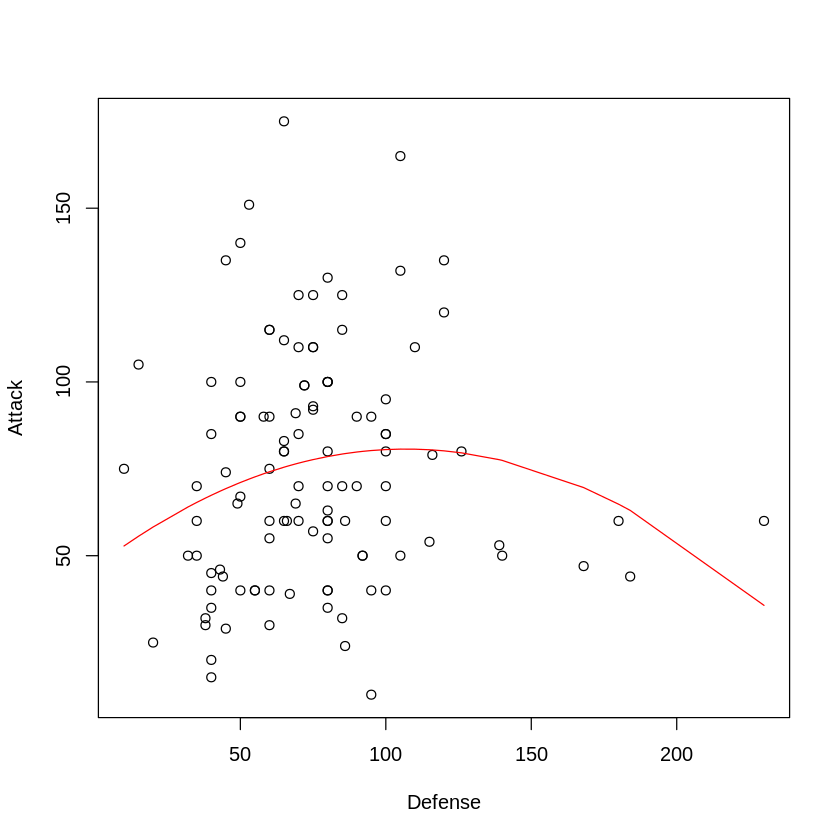

In [103]:
plot(x_plot_values, y_plot_values, xlab = "Defense", ylab= "Attack")
lines(sort(x_plot_values), parabolic_factors[1,1] * sort(x_plot_values)^2 + parabolic_factors[2,1] * sort(x_plot_values) + parabolic_factors[3,1], col="red")

In [ ]:
# x_plot_values <- defense_stats
# y_plot_values <- attack_stats

# for (i in 1:number_of_intervals){
#   for (j in 1:number_of_intervals){
#     if (correlation_table[i,j] != 0){
#       x_plot_values <- c(x_plot_values, x_centers[i])
#       y_plot_values <- c(y_plot_values, y_centers[j])
#     }
#   }
# }

# sample_intergroup_mean <- 0
# for (i in 1:number_of_intervals){
#   for (j in 1:number_of_intervals){
#     sample_intergroup_mean = sample_intergroup_mean + xym_multiplications[i,j]
#   }
# }
# sample_intergroup_mean = sample_intergroup_mean / sample_cardinality
# sprintf("Межгрупповое среднее = %f ", sample_intergroup_mean)
# p_xy <- r * y_std / x_std
# p_yx <- r * x_std / y_std
# sprintf("p_xy = %f ", p_xy)
# sprintf("p_yx = %f ", p_yx)

## Выводы
Развёрнутый вывод по практической работе.